# Test tiger with gamma location scale regression

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi

# Use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd

## Simulate data

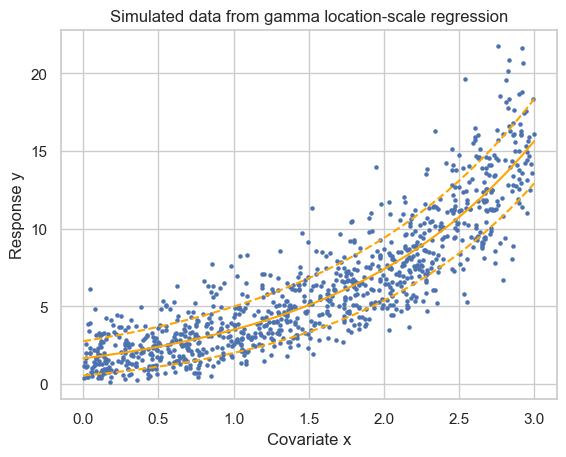

In [2]:
# Sample size and true parameters
n = 1000
true_beta = np.array([0.5, 0.75])
true_gamma = np.array([0.1, 0.3])

# Generate a key 
key = jax.random.PRNGKey(345)

# Data-generating process
key, *subkeys = jax.random.split(key, 3)
x0 = jax.random.uniform(key=subkeys[0], shape=(n,), minval=0, maxval=3)
X_mat = jnp.column_stack([jnp.ones(n), x0])
Z_mat = jnp.column_stack([jnp.ones(n), x0])
log_loc = X_mat @ true_beta
loc = jnp.exp(log_loc)
log_sigma = Z_mat @ true_gamma
sigma = jnp.exp(log_sigma)
alpha = loc**2/sigma**2
beta = loc/sigma**2
dist = tfjd.Gamma(concentration=alpha, rate=beta)
response_vec = dist.sample(sample_shape=(), seed=subkeys[1])

# Data to plot the linear regression line
x_plot = np.linspace(0, 3, num=200)
X_plot = np.column_stack([np.ones(200), x_plot])
Z_plot = np.column_stack([np.ones(200), x_plot])
mean_plot =  np.exp(X_plot @ true_beta)
sigma_plot = np.exp(Z_plot @ true_gamma)

# Set the seaborn theme
sns.set_theme(style="whitegrid")

# Plot the simulated data
plt.scatter(x0, response_vec, s = 5)
plt.plot(x_plot, mean_plot, color="orange")
plt.plot(x_plot, mean_plot - sigma_plot, color="orange", linestyle="--")
plt.plot(x_plot, mean_plot + sigma_plot, color="orange", linestyle="--")
plt.title("Simulated data from gamma location-scale regression")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Set up model in tigerpy

In [3]:
# Set up design matrix location
X = tiger.Obs(name = "X")
X.fixed(data = x0)

# Set up design matrix scale
Z = tiger.Obs(name = "Z")
Z.fixed(data = x0)

# Set up hyperparameters for the location
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters for the location
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# Set up hyperparameters for the scale
gamma_loc = tiger.Hyper(0.0, name="gamma_loc")
gamma_scale = tiger.Hyper(10.0, name="gamma_scale")

# Set up parameters for the scale
gamma_dist = tiger.Dist(tfjd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = tiger.Param(value=np.array([0.0, 0.0]), distribution=gamma_dist, name="gamma")

# Set up the linear predictors
lpred_loc = tiger.Lpred(obs=X, function=jnp.exp, name="loc", beta=beta)
lpred_scale = tiger.Lpred(obs=Z, function=jnp.exp, name="scale", gamma=gamma)

alpha_fn = lambda l, s: l**2/s**2
calc_alpha = tiger.Calc(alpha_fn, l=lpred_loc, s=lpred_scale)

beta_fn = lambda l, s: l/s**2
calc_beta = tiger.Calc(beta_fn, l=lpred_loc, s=lpred_scale)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Gamma, concentration=calc_alpha, rate=calc_beta)
m = tiger.Model(response=response_vec, distribution=response_dist)

In [4]:
m.log_prior

Array(-17.491264, dtype=float32)

In [6]:
jnp.sum(m.log_lik)

Array(-6159.7817, dtype=float32)

In [7]:
m.log_prior

Array(-17.491264, dtype=float32)

In [8]:
m.log_prob

Array(-6177.273, dtype=float32)

In [9]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [10]:
graph.logprob()

Array(-6177.273, dtype=float32)

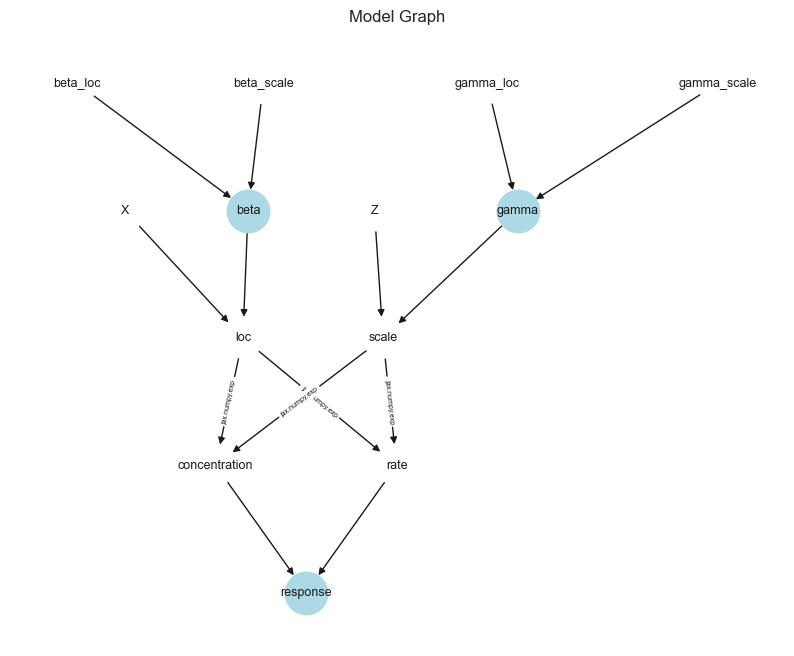

In [11]:
graph.visualize_graph()

## Inference with BBVI

In [17]:
q = bbvi.Bbvi(graph=graph,
              pre_train=True,
              loc_prec=1.0,
              scale_prec=2.0)

In [18]:
q.run_bbvi(key=jax.random.PRNGKey(27),
           learning_rate=0.001,
           pre_train_learning_rate=0.01,
           grad_clip=1,
           threshold=0.01,
           pre_train_threshold=0.1,
           batch_size=128,
           pre_train_batch_size=128,
           train_share=0.8,
           num_var_samples=64,
           chunk_size=50,
           epochs=250)

Start pre-training ...
Finished pre-training
Start optimization ...
Finished optimization


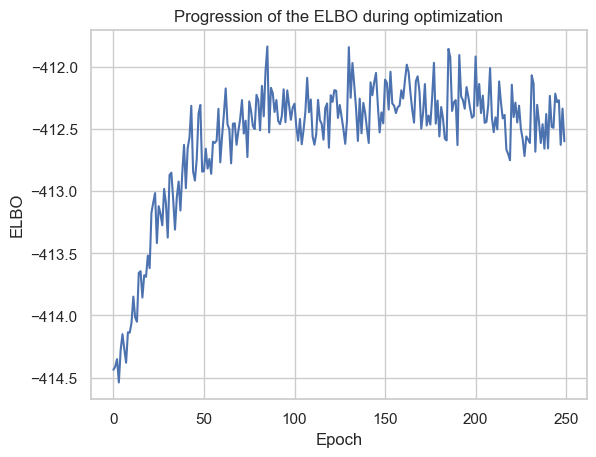

In [19]:
q.plot_elbo()

In [20]:
q.return_loc_params

{'beta': {'loc': Array([0.49981108, 0.7484728 ], dtype=float32)},
 'gamma': {'loc': Array([0.10595215, 0.30831113], dtype=float32)}}